In [94]:
from langchain_community.document_loaders import PyPDFLoader

path = "../../dataset/pdfs/anesthesia/1.pdf"

loader = PyPDFLoader(path)

pages = loader.load_and_split()

page_texts = [page.page_content for page in pages]


In [95]:
pages

[Document(metadata={'source': '../../dataset/pdfs/anesthesia/1.pdf', 'page': 1}, page_content='P1: SBT0521759385pre CUNY1088/Sladen 0 521 75938 5 June 23, 2007 13:27\nAnesthesia andCo-Existing Disease\nEdited by\nROBERT N. SLADEN, MD\nProfessor and Vice-ChairDepartment of AnesthesiologyChief, Division of Critical CareDirector, Cardiothoracic and Surgical Intensive Care UnitsColumbia UniversityCollege of Physicians and SurgeonsNew York, NY\nDOUGLAS B. COURSIN, MD\nProfessorDepartments of Anesthesiology and Internal MedicineUniversity of Wisconsin Medical SchoolMadison, WI\nJONATHAN T. KETZLER, MD\nAssociate ProfessorDepartments of Anesthesiology and Critical Care ServicesUniversity of Wisconsin Medical SchoolMadison, WI\nHUGH PLAYFORD, MD\nAssistant ProfessorDepartment of AnesthesiologyAssociate Program DirectorCritical Care FellowshipColumbia UniversityCollege of Physicians and SurgeonsNew York, NY\ni'),
 Document(metadata={'source': '../../dataset/pdfs/anesthesia/1.pdf', 'page': 2}, p

# Semantic Chunking using semantic router

In [96]:
from semantic_router.encoders import HuggingFaceEncoder

encoder = HuggingFaceEncoder(
    name = "NeuML/pubmedbert-base-embeddings"
)

encoder

HuggingFaceEncoder(name='NeuML/pubmedbert-base-embeddings', score_threshold=0.5, type='huggingface', tokenizer_kwargs={}, model_kwargs={}, device='cuda')

In [97]:
from semantic_chunkers import StatisticalChunker

chunker = StatisticalChunker(encoder=encoder)

In [98]:
document_text = "\n".join([page.page_content for page in pages])

In [99]:
chunks = chunker(docs=[document_text])

2024-10-14 18:59:49 INFO semantic_chunkers.utils.logger Single document exceeds the maximum token limit of 300. Splitting to sentences before semantically merging.


  0%|          | 0/252 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [19]:
chunks

[[Chunk(splits=['P1:', 'SBT0521759385pre CUNY1088/Sladen 0 521 75938 5 June 23, 2007 13:27', 'Anesthesia andCo-Existing Disease', 'Edited by', 'ROBERT N.', 'SLADEN, MD', 'Professor and Vice-ChairDepartment of AnesthesiologyChief, Division of Critical CareDirector, Cardiothoracic and Surgical Intensive Care UnitsColumbia UniversityCollege of Physicians and SurgeonsNew York, NY', 'DOUGLAS B.', 'COURSIN, MD', 'ProfessorDepartments of Anesthesiology and Internal MedicineUniversity of Wisconsin Medical SchoolMadison, WI', 'JONATHAN T.', 'KETZLER, MD', 'Associate ProfessorDepartments of Anesthesiology and Critical Care ServicesUniversity of Wisconsin Medical SchoolMadison, WI', 'HUGH PLAYFORD, MD', 'Assistant ProfessorDepartment of AnesthesiologyAssociate Program DirectorCritical Care FellowshipColumbia UniversityCollege of Physicians and SurgeonsNew York, NY', 'i', 'P1:', 'SBT0521759385pre CUNY1088/Sladen 0 521 75938 5 June 23, 2007 13:27', 'cambridge university press', 'Cambridge, New York

In [100]:
doc = []

for chunk in chunks[0]:  
    combined_chunk = " ".join(chunk.splits)  
    doc.append(Document(page_content=combined_chunk))  

print(f"Total documents: {len(doc)}")


Total documents: 839


# Custom Implementation

In [115]:
import networkx as nx

G = nx.Graph()

In [123]:
import matplotlib.pyplot as plt

def view_Graph(G):
    subax1 = plt.subplot(121)
    nx.draw(G, with_labels=True, font_weight='bold')
    subax2 = plt.subplot(122)
    nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')

Nodes: [('A', {'role': 'admin'}), ('B', {}), ('C', {}), ('D', {})]
Edges: [('A', 'B', {'relationship': 'friends'}), ('A', 'C', {}), ('B', 'D', {})]


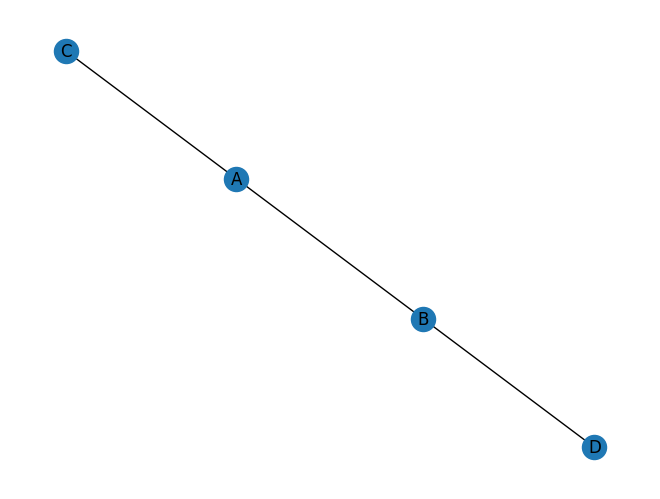

In [131]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

G.add_node("A", role="admin")
G.add_nodes_from(["B", "C", "D"])

G.add_edge("A", "B", relationship="friends")
G.add_edges_from([("A", "C"), ("B", "D")])

print("Nodes:", G.nodes(data=True))  
print("Edges:", G.edges(data=True))  

nx.draw(G, with_labels=True)
plt.show()

Nodes: [('Abc', {'role': 'user'}), ('efg', {}), ('hij', {}), ('kl', {})]
Edges: [('Abc', 'efg', {'relationship': 'friends'}), ('Abc', 'hij', {}), ('efg', 'kl', {})]


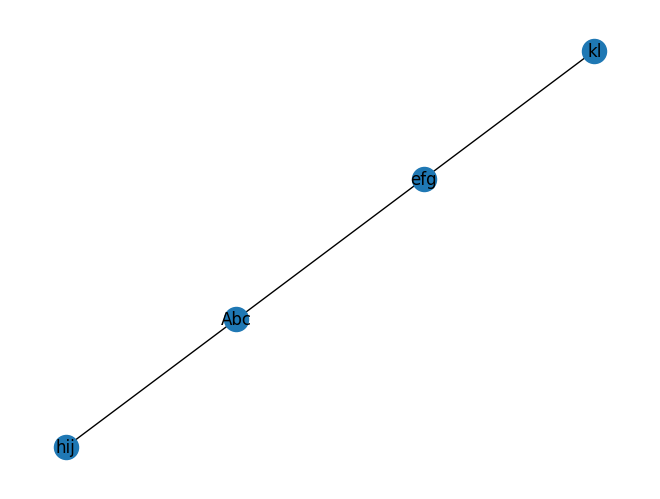

In [133]:
import networkx as nx
import matplotlib.pyplot as plt

F = nx.Graph()

F.add_node("Abc", role="user")
F.add_nodes_from(["efg", "hij", "kl"])

F.add_edge("Abc", "efg", relationship="friends")
F.add_edges_from([("Abc", "hij"), ("efg", "kl")])

print("Nodes:", F.nodes(data=True))  
print("Edges:", F.edges(data=True))  

nx.draw(F, with_labels=True)
plt.show()

Nodes: [('A', {'role': 'admin'}), ('B', {}), ('C', {}), ('D', {}), ('Abc', {'role': 'user'}), ('efg', {}), ('hij', {}), ('kl', {})]
Edges: [('A', 'B', {'relationship': 'friends'}), ('A', 'C', {}), ('B', 'D', {}), ('Abc', 'efg', {'relationship': 'friends'}), ('Abc', 'hij', {}), ('efg', 'kl', {})]


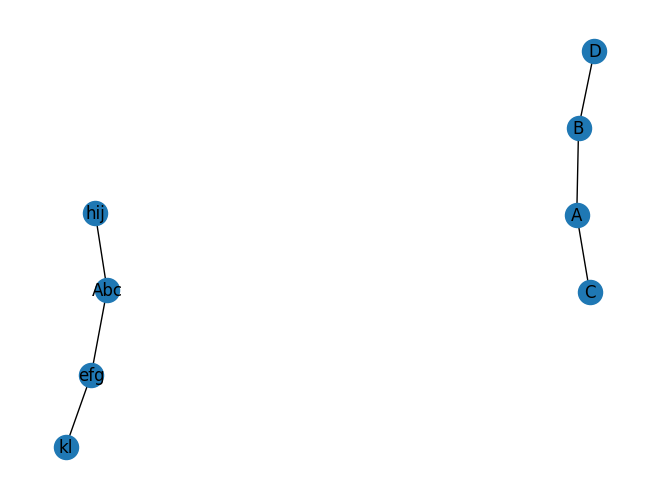

In [135]:
X= nx.union(G,F)

print("Nodes:", X.nodes(data=True))  
print("Edges:", X.edges(data=True))

nx.draw(X, with_labels=True)
plt.show()

# LLMGraphTransformer

In [101]:
entity_extraction_prompt = '''

Given a text document that is potentially relevant to this activity and a list of entity types, identify all entities of those types from the text and all relationships among the identified entities.

-Steps-
1. Identify all entities. For each identified entity, extract the following information:
- entity_name: Name of the entity, capitalized
- entity_type: Type of the entity, lowercased
- entity_description: Comprehensive description of the entity's attributes and activities
Format each entity as ("entity"{tuple_delimiter}<entity_name>{tuple_delimiter}<entity_type>{tuple_delimiter}<entity_description>

2. From the entities identified in step 1, identify all pairs of (source_entity, target_entity) that are *clearly related* to each other.
For each pair of related entities, extract the following information:
- source_entity: name of the source entity, as identified in step 1
- target_entity: name of the target entity, as identified in step 1
- relationship_description: explanation as to why you think the source entity and the target entity are related to each other
- relationship_strength: a numeric score indicating strength of the relationship between the source entity and target entity
 Format each relationship as ("relationship"{tuple_delimiter}<source_entity>{tuple_delimiter}<target_entity>{tuple_delimiter}<relationship_description>{tuple_delimiter}<relationship_strength>)

3. Return output in English as a single list of all the entities and relationships identified in steps 1 and 2. Use **{record_delimiter}** as the list delimiter.

4. When finished, output {completion_delimiter}

######################
-Examples-
######################
Example 1:

Entity_types: [person, technology, mission, organization, location]
Text:
while Alex clenched his jaw, the buzz of frustration dull against the backdrop of Taylor's authoritarian certainty. It was this competitive undercurrent that kept him alert, the sense that his and Jordan's shared commitment to discovery was an unspoken rebellion against Cruz's narrowing vision of control and order.

Then Taylor did something unexpected. They paused beside Jordan and, for a moment, observed the device with something akin to reverence. “If this tech can be understood..." Taylor said, their voice quieter, "It could change the game for us. For all of us.”

The underlying dismissal earlier seemed to falter, replaced by a glimpse of reluctant respect for the gravity of what lay in their hands. Jordan looked up, and for a fleeting heartbeat, their eyes locked with Taylor's, a wordless clash of wills softening into an uneasy truce.

It was a small transformation, barely perceptible, but one that Alex noted with an inward nod. They had all been brought here by different paths
################
Output:
("entity"{tuple_delimiter}"Alex"{tuple_delimiter}"person"{tuple_delimiter}"Alex is a character who experiences frustration and is observant of the dynamics among other characters."){record_delimiter}
("entity"{tuple_delimiter}"Taylor"{tuple_delimiter}"person"{tuple_delimiter}"Taylor is portrayed with authoritarian certainty and shows a moment of reverence towards a device, indicating a change in perspective."){record_delimiter}
("entity"{tuple_delimiter}"Jordan"{tuple_delimiter}"person"{tuple_delimiter}"Jordan shares a commitment to discovery and has a significant interaction with Taylor regarding a device."){record_delimiter}
("entity"{tuple_delimiter}"Cruz"{tuple_delimiter}"person"{tuple_delimiter}"Cruz is associated with a vision of control and order, influencing the dynamics among other characters."){record_delimiter}
("entity"{tuple_delimiter}"The Device"{tuple_delimiter}"technology"{tuple_delimiter}"The Device is central to the story, with potential game-changing implications, and is revered by Taylor."){record_delimiter}
("relationship"{tuple_delimiter}"Alex"{tuple_delimiter}"Taylor"{tuple_delimiter}"Alex is affected by Taylor's authoritarian certainty and observes changes in Taylor's attitude towards the device."{tuple_delimiter}7){record_delimiter}
("relationship"{tuple_delimiter}"Alex"{tuple_delimiter}"Jordan"{tuple_delimiter}"Alex and Jordan share a commitment to discovery, which contrasts with Cruz's vision."{tuple_delimiter}6){record_delimiter}
("relationship"{tuple_delimiter}"Taylor"{tuple_delimiter}"Jordan"{tuple_delimiter}"Taylor and Jordan interact directly regarding the device, leading to a moment of mutual respect and an uneasy truce."{tuple_delimiter}8){record_delimiter}
("relationship"{tuple_delimiter}"Jordan"{tuple_delimiter}"Cruz"{tuple_delimiter}"Jordan's commitment to discovery is in rebellion against Cruz's vision of control and order."{tuple_delimiter}5){record_delimiter}
("relationship"{tuple_delimiter}"Taylor"{tuple_delimiter}"The Device"{tuple_delimiter}"Taylor shows reverence towards the device, indicating its importance and potential impact."{tuple_delimiter}9){completion_delimiter}
#############################
Example 2:

Entity_types: [person, technology, mission, organization, location]
Text:
They were no longer mere operatives; they had become guardians of a threshold, keepers of a message from a realm beyond stars and stripes. This elevation in their mission could not be shackled by regulations and established protocols—it demanded a new perspective, a new resolve.

Tension threaded through the dialogue of beeps and static as communications with Washington buzzed in the background. The team stood, a portentous air enveloping them. It was clear that the decisions they made in the ensuing hours could redefine humanity's place in the cosmos or condemn them to ignorance and potential peril.

Their connection to the stars solidified, the group moved to address the crystallizing warning, shifting from passive recipients to active participants. Mercer's latter instincts gained precedence— the team's mandate had evolved, no longer solely to observe and report but to interact and prepare. A metamorphosis had begun, and Operation: Dulce hummed with the newfound frequency of their daring, a tone set not by the earthly
#############
Output:
("entity"{tuple_delimiter}"Washington"{tuple_delimiter}"location"{tuple_delimiter}"Washington is a location where communications are being received, indicating its importance in the decision-making process."){record_delimiter}
("entity"{tuple_delimiter}"Operation: Dulce"{tuple_delimiter}"mission"{tuple_delimiter}"Operation: Dulce is described as a mission that has evolved to interact and prepare, indicating a significant shift in objectives and activities."){record_delimiter}
("entity"{tuple_delimiter}"The team"{tuple_delimiter}"organization"{tuple_delimiter}"The team is portrayed as a group of individuals who have transitioned from passive observers to active participants in a mission, showing a dynamic change in their role."){record_delimiter}
("relationship"{tuple_delimiter}"The team"{tuple_delimiter}"Washington"{tuple_delimiter}"The team receives communications from Washington, which influences their decision-making process."{tuple_delimiter}7){record_delimiter}
("relationship"{tuple_delimiter}"The team"{tuple_delimiter}"Operation: Dulce"{tuple_delimiter}"The team is directly involved in Operation: Dulce, executing its evolved objectives and activities."{tuple_delimiter}9){completion_delimiter}
#############################
Example 3:

Entity_types: [person, role, technology, organization, event, location, concept]
Text:
their voice slicing through the buzz of activity. "Control may be an illusion when facing an intelligence that literally writes its own rules," they stated stoically, casting a watchful eye over the flurry of data.

"It's like it's learning to communicate," offered Sam Rivera from a nearby interface, their youthful energy boding a mix of awe and anxiety. "This gives talking to strangers' a whole new meaning."

Alex surveyed his team—each face a study in concentration, determination, and not a small measure of trepidation. "This might well be our first contact," he acknowledged, "And we need to be ready for whatever answers back."

Together, they stood on the edge of the unknown, forging humanity's response to a message from the heavens. The ensuing silence was palpable—a collective introspection about their role in this grand cosmic play, one that could rewrite human history.

The encrypted dialogue continued to unfold, its intricate patterns showing an almost uncanny anticipation
#############
Output:
("entity"{tuple_delimiter}"Sam Rivera"{tuple_delimiter}"person"{tuple_delimiter}"Sam Rivera is a member of a team working on communicating with an unknown intelligence, showing a mix of awe and anxiety."){record_delimiter}
("entity"{tuple_delimiter}"Alex"{tuple_delimiter}"person"{tuple_delimiter}"Alex is the leader of a team attempting first contact with an unknown intelligence, acknowledging the significance of their task."){record_delimiter}
("entity"{tuple_delimiter}"Control"{tuple_delimiter}"concept"{tuple_delimiter}"Control refers to the ability to manage or govern, which is challenged by an intelligence that writes its own rules."){record_delimiter}
("entity"{tuple_delimiter}"Intelligence"{tuple_delimiter}"concept"{tuple_delimiter}"Intelligence here refers to an unknown entity capable of writing its own rules and learning to communicate."){record_delimiter}
("entity"{tuple_delimiter}"First Contact"{tuple_delimiter}"event"{tuple_delimiter}"First Contact is the potential initial communication between humanity and an unknown intelligence."){record_delimiter}
("entity"{tuple_delimiter}"Humanity's Response"{tuple_delimiter}"event"{tuple_delimiter}"Humanity's Response is the collective action taken by Alex's team in response to a message from an unknown intelligence."){record_delimiter}
("relationship"{tuple_delimiter}"Sam Rivera"{tuple_delimiter}"Intelligence"{tuple_delimiter}"Sam Rivera is directly involved in the process of learning to communicate with the unknown intelligence."{tuple_delimiter}9){record_delimiter}
("relationship"{tuple_delimiter}"Alex"{tuple_delimiter}"First Contact"{tuple_delimiter}"Alex leads the team that might be making the First Contact with the unknown intelligence."{tuple_delimiter}10){record_delimiter}
("relationship"{tuple_delimiter}"Alex"{tuple_delimiter}"Humanity's Response"{tuple_delimiter}"Alex and his team are the key figures in Humanity's Response to the unknown intelligence."{tuple_delimiter}8){record_delimiter}
("relationship"{tuple_delimiter}"Control"{tuple_delimiter}"Intelligence"{tuple_delimiter}"The concept of Control is challenged by the Intelligence that writes its own rules."{tuple_delimiter}7){completion_delimiter}
#############################
-Real Data-
######################
Text: {input_text}
######################
Output:

'''

In [107]:
from langchain_core.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain_groq import ChatGroq
from langchain_ollama import ChatOllama
import os
from dotenv import load_dotenv

load_dotenv()


prompt = PromptTemplate(
    template = entity_extraction_prompt
    
)

llm_groq = ChatGroq(
    groq_api_key = os.getenv("groq_api"),
    model_name = "gemma2-9b-it"
)

llm_ollama = ChatOllama(
    model = "gemma2:9b",
)

query_chain = LLMChain(
    llm = llm_groq,
    prompt = prompt
)

In [74]:
doc[5].page_content

'the best treatment for the patient. Therefore, the author(s), edi-tors, contributors, and the publisher make no warranty, expressor implied, and shall have no liability to any person or entity withregard to claims, loss, or damage caused, or alleged to be caused, directly or indirectly, by the use of information contained in thispublication.Further, the author(s), editors, contributors, and the publisher are not responsible for misuse of any of the information pro-vided in this publication, for negligence by the user, or for anytypographical errors.'

In [103]:
query = doc[5].page_content 

response = query_chain.invoke({
    'completion_delimiter': '<COMP>', 
    'tuple_delimiter': '|',
    'record_delimiter': '<END>',
    'input_text': query
})

response

{'completion_delimiter': '<COMP>',
 'tuple_delimiter': '|',
 'record_delimiter': '<END>',
 'input_text': 'the best treatment for the patient. Therefore, the author(s), edi-tors, contributors, and the publisher make no warranty, expressor implied, and shall have no liability to any person or entity withregard to claims, loss, or damage caused, or alleged to be caused, directly or indirectly, by the use of information contained in thispublication.Further, the author(s), editors, contributors, and the publisher are not responsible for misuse of any of the information pro-vided in this publication, for negligence by the user, or for anytypographical errors.',
 'text': '("entity"|"patient"|"person"|"The patient is the individual receiving medical treatment.")<END>\n("entity"|"author(s)"|"person"|"The authors are the creators of the medical publication.")<END>\n("entity"|"editors"|"person"|"The editors are individuals responsible for overseeing the content of the medical publication.")<END>\

In [78]:
print(response['text'])

("entity"|"The author(s)"|"person"|"The authors are the individuals responsible for creating the content of the publication.")<END>
("entity"|"editors"|"person"|"The editors are involved in the production and review of the publication.")<END>
("entity"|"contributors"|"person"|"The contributors are individuals who have provided content to the publication.")<END>
("entity"|"the publisher"|"organization"|"The publisher is the entity responsible for distributing the publication.")<END>
("entity"|"patient"|"person"|"The patient is the individual receiving medical treatment.")<END>
("relationship"|"The author(s)"|"The patient"|"The author(s) provide information related to the treatment of the patient.")<END>
("relationship"|"editors"|"The patient"|"The editors review and approve information related to the patient's treatment.")<END>
("relationship"|"contributors"|"The patient"|"The contributors provide information related to the patient's treatment.")<END>
("relationship"|"the publisher"|"Th

In [108]:
from langchain_experimental.graph_transformers import LLMGraphTransformer


llm_transformer = LLMGraphTransformer(
    llm = llm_ollama
)

In [109]:
graph_documents = []

In [ ]:
from tqdm import tqdm

for i, document in enumerate(tqdm(doc, desc="Converting pages to graph documents")):

    # if(i>182):

        try:

            temp = llm_transformer.convert_to_graph_documents([document])

            graph_documents.append(temp)
        
        except Exception as e:

            print(f"Failed to generate graph for page {i} {e}")
    # else:
    #     pass

In [87]:
graph_documents

[]

In [2]:
from neo4j import GraphDatabase

local_user = 'neo4j'
local_url = 'bolt://localhost:7687'
local_password = 'qazplmg123456'

driver = GraphDatabase.driver(
    uri = local_url,
    auth = (local_user, local_password)
)